In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit
import astropy
import astropy.units as u
import corner
from astropy.cosmology import w0waCDM

In [2]:
# Astropy.cosmology version.Here I am using FlatwowaCDM because it has less parameters.(no Ode)
def Hz1(z1,H01,Om1,w01,wa1):
    Ode1=1-Om1
    cosmo =w0waCDM(H0=H01* u.km / u.s / u.Mpc, Om0=Om1,Ode0=1-Om1,w0=w01,wa=wa1) 
    #the redshift dependence of the dark energy density:
    I = cosmo.de_density_scale(z1)
    E = np.sqrt((Om1*(1+z1)**3.) + (1.-Om1)*I)
    HZ1 = H01*E
    return HZ1

In [3]:
#Define  random redshifts
num_zs = 1000
zs= np.linspace(0.01, 3., num=num_zs)

In [4]:
#From Planck observations for CPL mode
O_m= 0.291
O_de= 1-O_m
w_0= -0.961
w_1= -0.28
H_0= 68.34

In [5]:
#Hubble comoving parameter
Hz=Hz1(zs,H_0,O_m,w_0,w_1)/(1+zs)

In [6]:
#random error for Hz
error_sigma = 0.5
e1 = np.random.normal(0., error_sigma, Hz.shape)


In [7]:
H_zz= Hz + e1

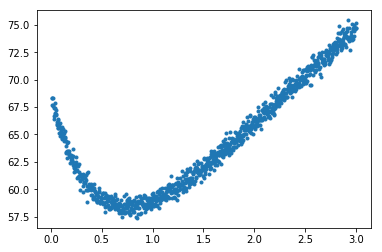

In [8]:
plt.plot(zs,H_zz, '.')

In [9]:
import scipy.odr as odr

In [11]:
p = lmfit.Parameters()
p.add_many(('Om1',0.3,True,0.,2.),
           ('H01',70.0,True,50.,100.),
           ('w01',-1.0,True,-2.,2.),
           ('wa1',-0.1,True,-1.,1.))

def residual(p):
    v = p.valuesdict()
    return (Hz1(zs,v['H01'],v['Om1'],v['w01'],v['wa1'])-H_zz)/error_sigma

In [12]:
def perform_odr(Hz1, Hz, error_sigma, e1):
    """Finds the ODR for data {x, y} and returns the result"""
    linear= odr.Model(Hz1)
    mydata = odr.Data(Hz1, Hz, wd=1./error_sigma, we=1./e1)
    myodr = odr.ODR(mydata, linear, beta0=[0])
    output = myodr.run()
    return output


In [13]:
regression = perform_odr(Hz, H_zz,error_sigma,e1)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
mi = lmfit.minimize(residual, p, method='leastsq', nan_policy='omit')

In [ ]:
plt.errorbar(zs,H_zz,yerr=error_sigma,fmt='o',alpha=0.2)
bestOm1 = mi.params.valuesdict()['Om1']
#bestOde1= mi.params.valuesdict()['Ode1']
bestH01 = mi.params.valuesdict()['H01']
bestw01 = mi.params.valuesdict()['w01']
bestwa1 = mi.params.valuesdict()['wa1']
plt.plot(zs,Hz1(zs,bestH01,bestOm1,bestw01,bestwa1))
plt.plot(zs,Hz)
plt.xlabel('Redshift (z)')
plt.ylabel('Comoving Hubble parameter')
lmfit.report_fit(mi)

In [ ]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300, steps=1500,thin=1,
                         params=p, is_weighted=True)

In [ ]:
corner.corner(res.flatchain,labels=res.var_names, truths=list(res.params.valuesdict().values()))

In [ ]:
plt.plot(res.flatchain.H01)